counter example

In [1]:
# # # install spicy-snow in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install spicy-snow
# !pip install contextily

In [2]:
!pip install -q pystac-client
!pip install -q planetary-computer
!pip install -q odc-stac

In [3]:
# import spicy-snow functions and other required packages
# depending on your environment, you may need to install some of these
import sys
sys.path.append('../../../spicy-snow/')
from spicy_snow.retrieval import retrieve_snow_depth, retrieve_snow_depth_fake_ims 
from spicy_snow.IO.user_dates import get_input_dates
import geopandas as gpd
from pathlib import Path
from shapely import geometry
# for optional plotting
import contextily as cx 
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import pystac_client
import planetary_computer
import odc.stac
import numpy as np
import pandas as pd

In [4]:
# to use lat-lon range for aoi
#area = geometry.box(-113.2, 43, -113, 43.4)

# to use geojson for aoi
# geojson is expected to be in wgs84. 
area_gdf = gpd.read_file('data/north_of_pheonix.geojson')
area = list(area_gdf.geometry)[0].envelope # convert feature to box for search

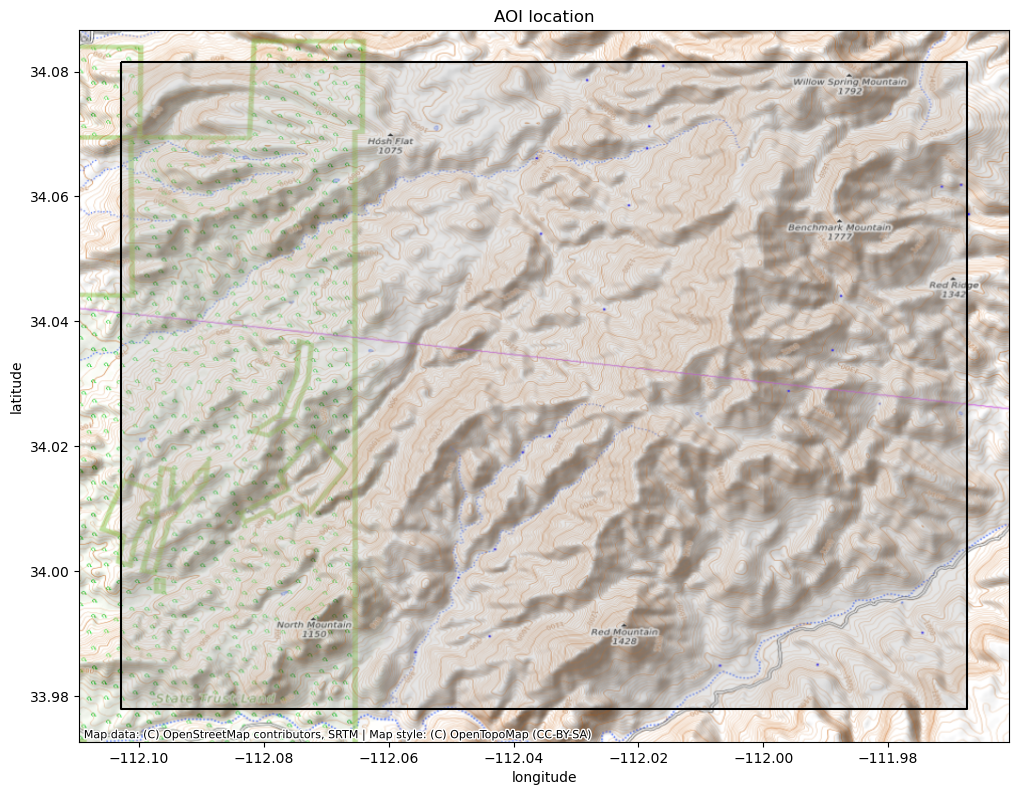

In [5]:
# Plot aoi
fig, ax = plt.subplots(figsize=(12,12))
area_gdf.plot(ax=ax,
              color='darkgrey',
              alpha=0.3)
area_gdf.boundary.plot(ax=ax,
                       color='k')

cx.add_basemap(ax=ax, crs=area_gdf.crs.to_string(), source=cx.providers.OpenTopoMap);
ax.set_xlabel('longitude');
ax.set_ylabel('latitude');
ax.set_title('AOI location');

In [6]:
# this will generate a tuple of dates from the previous August 1st to this date
dates = get_input_dates('2021-07-31') # run on all S1 images from 2020-08-01 through 2021-07-31

# define output directory and file name
out_nc = Path(f'data/sd_{dates[0]}_{dates[1]}.nc').expanduser()

spicy_ds = retrieve_snow_depth_fake_ims(area = area, dates = dates, 
                               work_dir = Path('/tmp/er_test/').expanduser(), 
                               job_name = f'sd_{dates[0]}_{dates[1]}',
                               existing_job_name = f'sd_{dates[0]}_{dates[1]}',
                               debug=False,
                               outfp=out_nc)
# the only change in this "fake_ims" is adding a line after download_snow_cover:
# ds['ims'] = xr.where((ds['ims'].time<pd.to_datetime('2020-10-15')) | (ds['ims'].time>pd.to_datetime('2021-07-01')) ,0,4)

(spicy-snow spicy_snow.utils.spicy_logging INFO) Found 90 results


Combining Sentinel-1 dataArrays: 100%|██████████| 90/90 [01:21<00:00,  1.10it/s]

(spicy-snow spicy_snow.utils.spicy_logging INFO) fcf.tif already exists. Skipping.


(spicy-snow spicy_snow.utils.spicy_logging INFO) Preprocessing Sentinel-1 images
(spicy-snow spicy_snow.utils.spicy_logging INFO) Calculating snow index
(spicy-snow spicy_snow.utils.spicy_logging INFO) Flag wet snow


In [7]:
#spicy_ds = xr.open_mfdataset('./data/sd_2020-08-01_2021-07-31.nc')

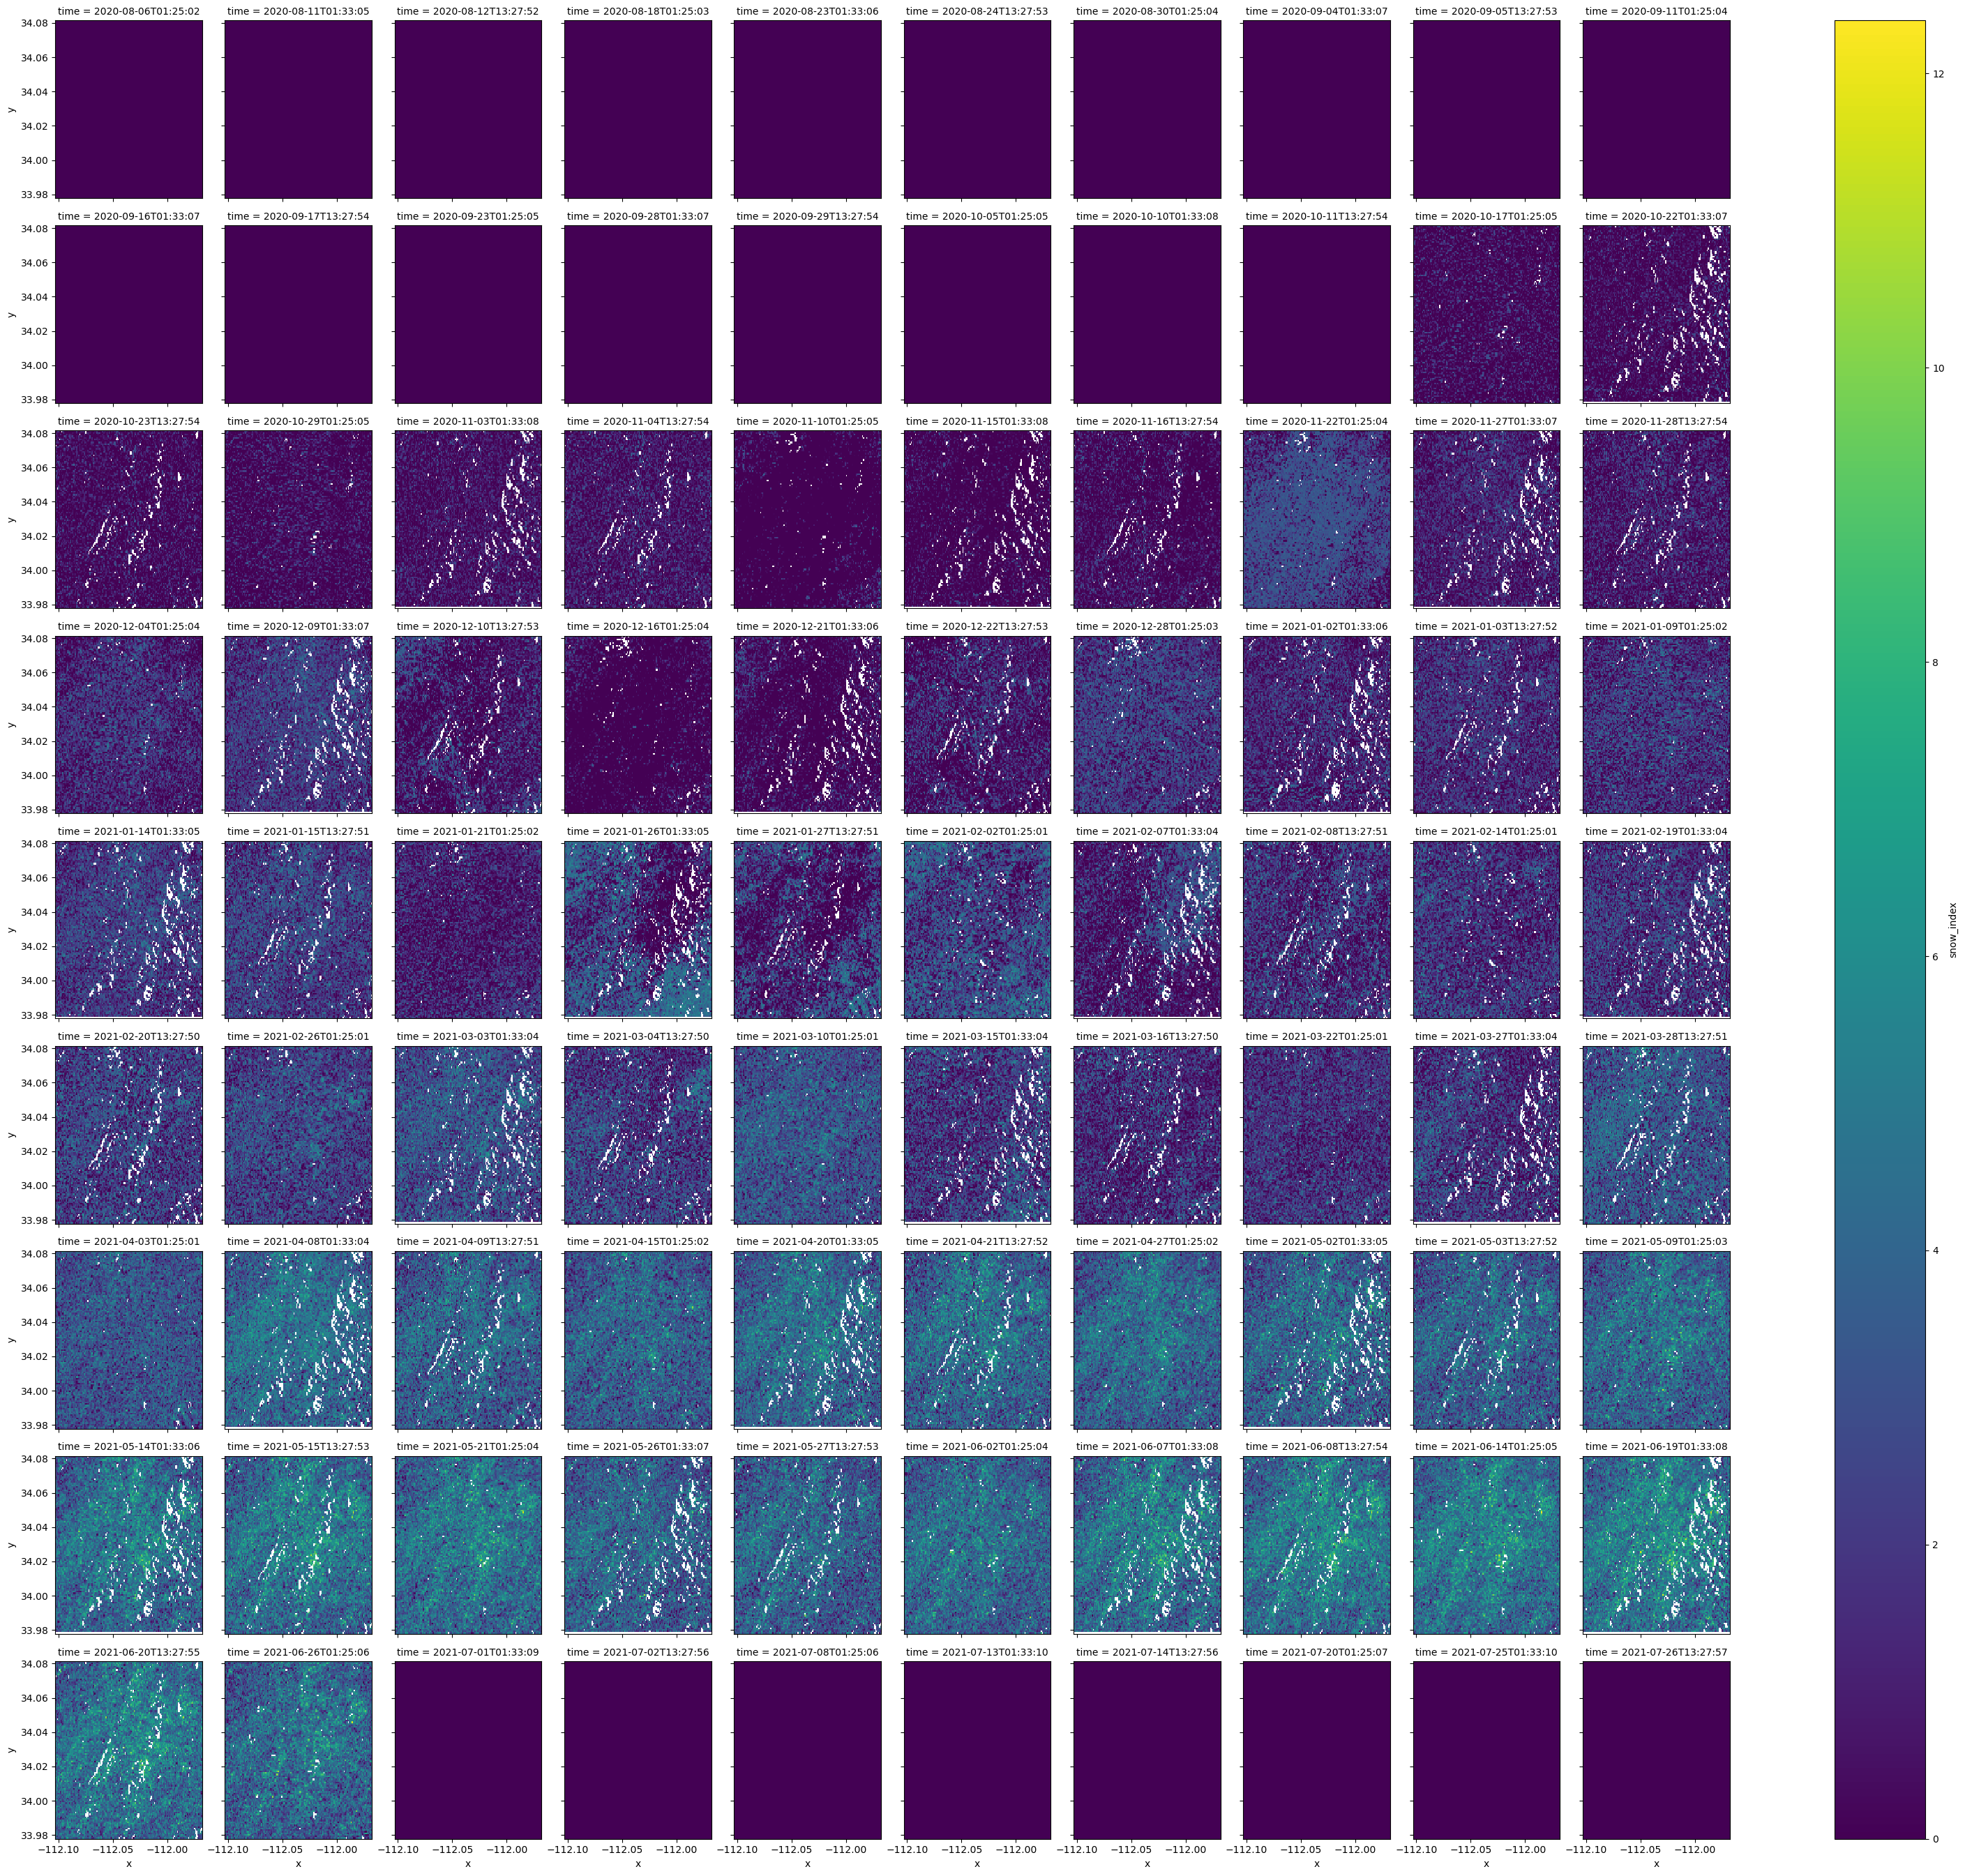

In [8]:
spicy_ds['snow_index'].plot(col='time',col_wrap=10)

In [13]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1" ,modifier=planetary_computer.sign_inplace)
search = catalog.search(collections="cop-dem-glo-30", bbox=spicy_ds.rio.bounds())
items = list(search.get_items())

In [14]:
dem_raster_all = odc.stac.load(items, bbox=spicy_ds.rio.bounds()).squeeze()
dem_raster = dem_raster_all['data']
dem_raster = dem_raster.rio.set_nodata(np.NaN)

dem = dem_raster.rio.reproject_match(spicy_ds)
spicy_ds['dem'] = dem


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


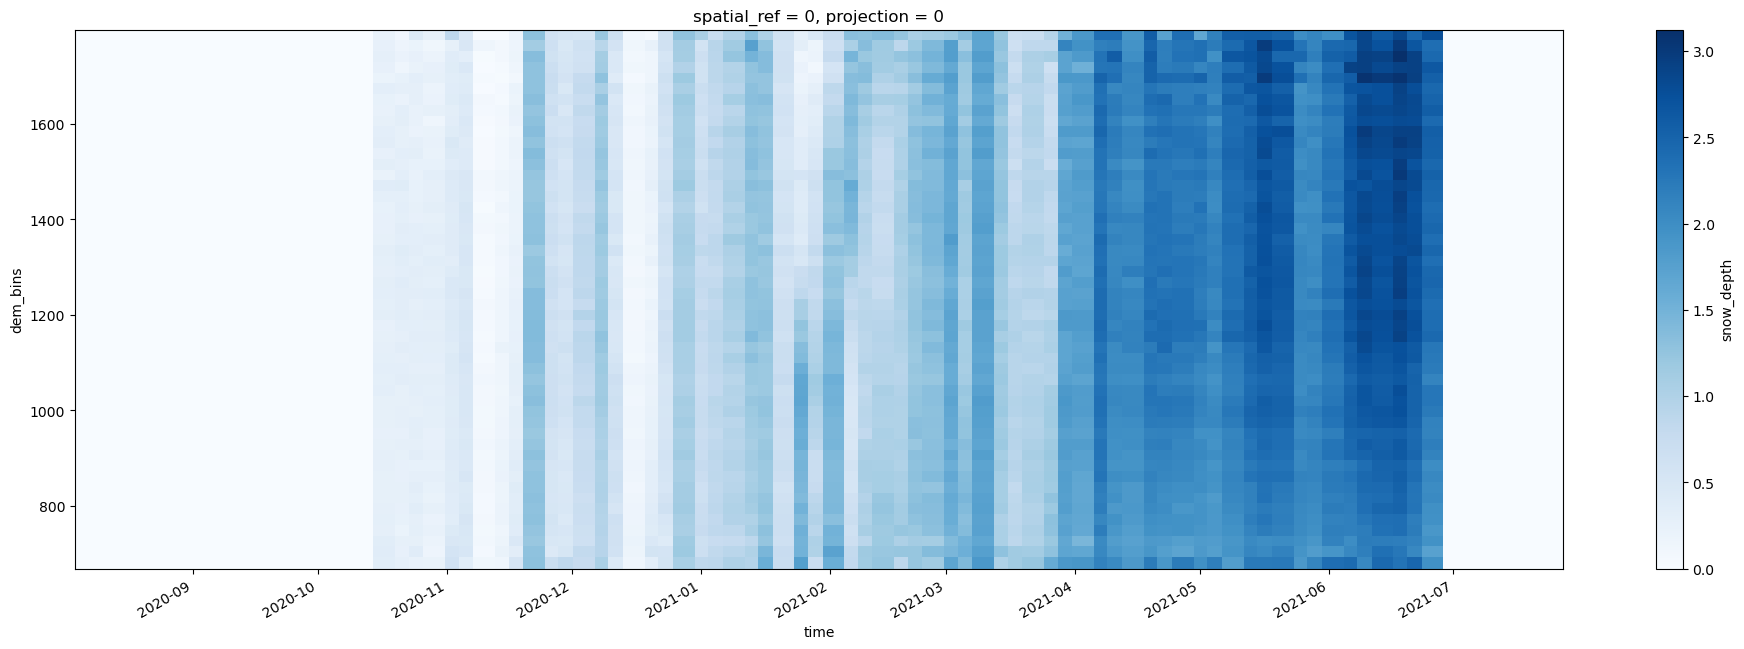

In [15]:
f,ax=plt.subplots(figsize=(24,7))
spicy_ds.groupby_bins(group='dem',bins=50).mean()['snow_depth'].plot(ax=ax,cmap='Blues')